Model definition, training and evaluation

In [1]:
# --- Import libraries ---
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from collections import Counter
from sklearn.preprocessing import label_binarize

from torchvision.io import read_image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

from PIL import Image 
import cv2
from torchvision import transforms
import torch.nn.functional as F

In [2]:
# --- Import preprocessing function ---
from data_preprocessing import get_dataloaders

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# --- Load DataLoaders ---
#train_loader, val_loader, test_loader = get_dataloaders(
    #train_directory = "C:/Users/sapph/Code_Projects/her2_expression/HE_images/train",
    #test_directory = "C:/Users/sapph/Code_Projects/her2_expression/HE_images/test",
    #batch_size = 32
#)
#print("DataLoaders loaded successfully!")

# --- Swap to these when using hopper ---
train_loader, val_loader, test_loader = get_dataloaders(
    train_directory = "/scratch/mmakula/BCI_dataset/HE/train",
    test_directory = "/scratch/mmakula/BCI_dataset/HE/test",
    batch_size = 32
)
print("DataLoaders loaded successfully!")

DataLoaders loaded successfully!


In [5]:
# --- Determine class distribution in training set ---
training_labels = [label for _, label in train_loader.dataset]
print("Training HER2 expression levels:", Counter(training_labels))

Training HER2 expression levels: Counter({2: 937, 3: 595, 1: 548, 0: 128})


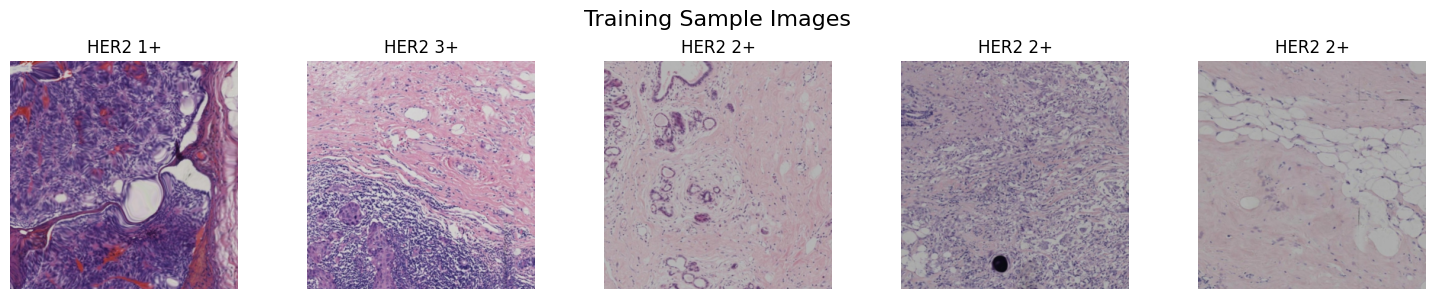

In [6]:
# --- Visualizing Training Sample Images ---

classes = ["HER2 0", "HER2 1+", "HER2 2+", "HER2 3+"]

figure = plt.figure(figsize=(15, 3))
cols, rows = 5, 1
dataset = train_loader.dataset
figure.suptitle("Training Sample Images", fontsize = 16)

for i in range(1, cols * rows + 1): 
    sample_idx = torch.randint(len(dataset), size = (1,)).item() 
    img, label = dataset[sample_idx]
    
    if isinstance(img, torch.Tensor): 
        img = img.permute(1, 2, 0)# converts CxHxW to HxWxC
    
    figure.add_subplot(rows, cols, i) 
    plt.title(classes[label]) 
    plt.axis("off") 
    plt.imshow(img) 
plt.tight_layout(rect = [0, 0, 1, 1])
plt.show()

In [7]:
# --- Create class weights ---
class_counts = Counter(training_labels)

total_samples = sum(class_counts.values())
num_classes = len(class_counts)

class_weights = torch.tensor([total_samples / (num_classes * class_counts[i]) for i in range (num_classes)], dtype = torch.float32).to(device)
print(f"Class Weights: {class_weights}")

Class Weights: tensor([4.3125, 1.0073, 0.5891, 0.9277], device='cuda:0')


In [8]:
# --- Define Model ---
class InceptionBlock(nn.Module):
    def __init__(self, in_channels):
        super(InceptionBlock, self).__init__()
        # 1x1 conv branch
        self.branch1 = nn.Conv2d(in_channels, 32, kernel_size=1)

        # 1x1 conv -> 3x3 conv branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(32, 48, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace = True)
        )

        # 1x1 conv -> 5x5 conv branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(16, 24, kernel_size = 5, padding = 2),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace = True)
        )

        # 3x3 maxpool -> 1x1 conv branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1),
            nn.Conv2d(in_channels, 16, kernel_size = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace = True)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = torch.cat([branch1, branch2, branch3, branch4], dim = 1)
        return outputs

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.inception = InceptionBlock(in_channels = 3)  

        self.features = nn.Sequential(
            nn.Conv2d(120, 128, kernel_size=3, padding = 1),  # 120 channels from Inception output
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            InceptionBlock(in_channels = 128), 
            
            nn.Conv2d(120, 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            InceptionBlock(in_channels = 256),
            
            nn.Conv2d(120, 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            InceptionBlock(in_channels = 256),
            
            nn.Conv2d(120, 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 1024, kernel_size=3, padding=2), 
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(1024,512), 
            nn.ReLU(inplace = True),
            nn.Dropout(),
            nn.Linear(512, 256), 
            nn.ReLU(inplace = True),
            nn.Dropout(), 
            nn.Linear(256, 4)  # 4 classes
        )

    def forward(self, x):
        x = self.inception(x)
        x = self.features(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [9]:
HER2_expression_model = CustomCNN().to(device)
print(HER2_expression_model)

CustomCNN(
  (inception): InceptionBlock(
    (branch1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    (branch2): Sequential(
      (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (branch3): Sequential(
      (0): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (branch4): Sequential(
      (0): MaxPool2d(kernel_size=3, stride=

In [10]:
# --- Define number of epochs ---
n_epochs = 60 

In [11]:
# --- Train Model ---
HER2_expression_model.train()

optimizer = torch.optim.Adam(HER2_expression_model.parameters(), lr=0.0001, weight_decay = 0.0001)
loss_fn = nn.CrossEntropyLoss(weight = class_weights)


losses = []
for epoch in range(n_epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = HER2_expression_model(images)
        loss = loss_fn(predictions, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Report epochs
    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)  # append only one value per epoch
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")

torch.save(HER2_expression_model.state_dict(), "her2_cnn_model.pth")
print("Model saved as her2_cnn_model.pth!")

Epoch 1/60, Loss: 1.2676


Epoch 2/60, Loss: 1.0984


Epoch 3/60, Loss: 1.0943


Epoch 4/60, Loss: 1.0191


Epoch 5/60, Loss: 1.0060


Epoch 6/60, Loss: 0.9425


Epoch 7/60, Loss: 0.8869


Epoch 8/60, Loss: 0.8781


Epoch 9/60, Loss: 0.8276


Epoch 10/60, Loss: 0.8129


Epoch 11/60, Loss: 0.7790


Epoch 12/60, Loss: 0.7743


Epoch 13/60, Loss: 0.8023


Epoch 14/60, Loss: 0.7229


Epoch 15/60, Loss: 0.8166


Epoch 16/60, Loss: 0.7031


Epoch 17/60, Loss: 0.6888


Epoch 18/60, Loss: 0.6789


Epoch 19/60, Loss: 0.6798


Epoch 20/60, Loss: 0.6395


Epoch 21/60, Loss: 0.6544


Epoch 22/60, Loss: 0.6542


Epoch 23/60, Loss: 0.5890


Epoch 24/60, Loss: 0.5767


Epoch 25/60, Loss: 0.5625


Epoch 26/60, Loss: 0.5593


Epoch 27/60, Loss: 0.5522


Epoch 28/60, Loss: 0.5415


Epoch 29/60, Loss: 0.4777


Epoch 30/60, Loss: 0.4945


Epoch 31/60, Loss: 0.5261


Epoch 32/60, Loss: 0.4491


Epoch 33/60, Loss: 0.4854


Epoch 34/60, Loss: 0.4968


Epoch 35/60, Loss: 0.5129


Epoch 36/60, Loss: 0.4214


Epoch 37/60, Loss: 0.3951


Epoch 38/60, Loss: 0.4689


Epoch 39/60, Loss: 0.3934


Epoch 40/60, Loss: 0.4464


Epoch 41/60, Loss: 0.3713


Epoch 42/60, Loss: 0.4084


Epoch 43/60, Loss: 0.4167


Epoch 44/60, Loss: 0.3575


Epoch 45/60, Loss: 0.3414


Epoch 46/60, Loss: 0.3363


Epoch 47/60, Loss: 0.3120


Epoch 48/60, Loss: 0.3629


Epoch 49/60, Loss: 0.3311


Epoch 50/60, Loss: 0.2941


Epoch 51/60, Loss: 0.3232


Epoch 52/60, Loss: 0.3511


Epoch 53/60, Loss: 0.3440


Epoch 54/60, Loss: 0.2778


Epoch 55/60, Loss: 0.3601


Epoch 56/60, Loss: 0.2748


Epoch 57/60, Loss: 0.2902


Epoch 58/60, Loss: 0.3396


Epoch 59/60, Loss: 0.2470


Epoch 60/60, Loss: 0.2943
Model saved as her2_cnn_model.pth!


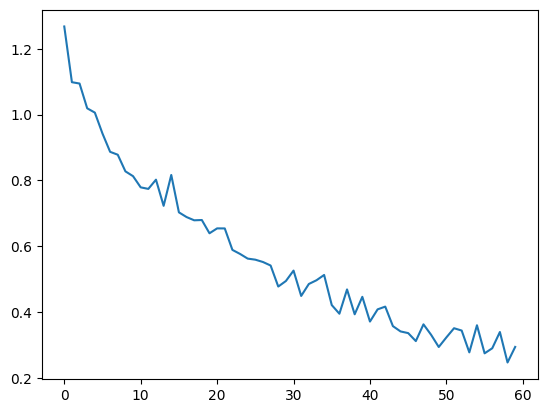

In [12]:
# --- Loss Plot ---
fig, ax = plt.subplots()
ax.plot(losses)

Training Set Evaluation


Accuracy: 0.9157608695652174
Precision (macro): 0.8781076942001897
Recall (macro): 0.9336330252251404


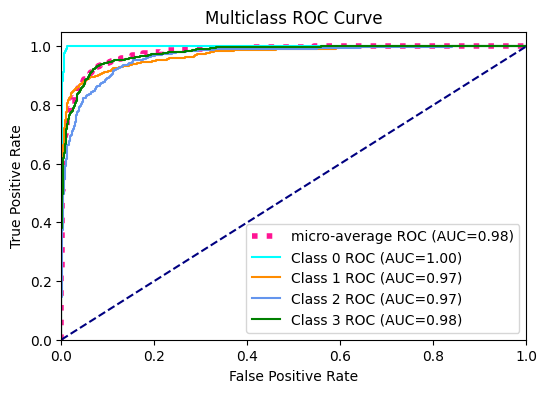


Validation Set Evaluation


Accuracy: 0.8802177858439202
Precision (macro): 0.8220335324154451
Recall (macro): 0.904287312450645


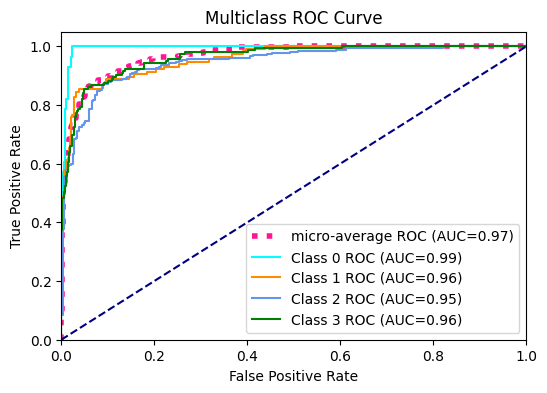

In [13]:
# -- Evaluate Model --
HER2_expression_model.eval()

def evaluate_model(loader, model, num_classes):
    y_true = []
    y_pred = []
    y_prob = []
    
    for images, labels in loader:
        images = images.to(device).float()
        labels = labels.cpu().numpy()
        
        outputs = model(images).cpu().detach().numpy()
        predictions = np.argmax(outputs, axis = 1)
        
        y_true.extend(labels)
        y_pred.extend(predictions)
        y_prob.extend(outputs)
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)
    
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (macro):", precision_score(y_true, y_pred, average = "macro"))
    print("Recall (macro):", recall_score(y_true, y_pred, average = "macro"))
    
    # --- ROC-AUC curves ---
    try:
        y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Micro-average curve ("global" curve that considers all predictions equally)
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Plot ROC curves
        plt.figure(figsize=(6, 4))
        plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average ROC (AUC={roc_auc['micro']:.2f})", color="deeppink", linestyle=":", linewidth=4)
        colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
        for i, color in zip(range(num_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, label=f"Class {i} ROC (AUC={roc_auc[i]:.2f})")
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Multiclass ROC Curve")
        plt.legend(loc="lower right")
        plt.show()

    except Exception as e:
        print("ROC-AUC could not be calculated:", e)

# --- Training Set Evaluation ---
print("Training Set Evaluation")
evaluate_model(train_loader, HER2_expression_model, num_classes = 4)

# --- Validation Set Evaluation ---
print("\nValidation Set Evaluation")
evaluate_model(val_loader, HER2_expression_model, num_classes = 4)
        

In [14]:
# --- Grad-CAM ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Hooks
        self.fwd_hook = target_layer.register_forward_hook(self.save_activation)
        self.bwd_hook = target_layer.register_full_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def __call__(self, x, target_class):
        output = self.model(x)
        score = output[0, target_class]
        
        self.model.zero_grad()
        score.backward(retain_graph = True)

        weights = self.gradients.mean(dim = (2, 3), keepdim = True)
        cam = (weights * self.activations).sum(dim = 1, keepdim = True)
        cam = F.relu(cam)

        # Normalize CAM to [0,1]
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)
        return cam

    def remove_hooks(self):
        self.fwd_hook.remove()
        self.bwd_hook.remove()

In [15]:
# --- Visualize Grad-CAM ---
model = CustomCNN().to(device)
model.load_state_dict(torch.load("her2_cnn_model.pth", map_location = device))
model.eval()

cam_generator = GradCAM(model, model.features[19])

images, labels = next(iter(val_loader))
images = images.to(device) 
labels = labels.to(device) 

# predicted class labels
with torch.no_grad():
    outputs = model(images)
    predicted_classes = outputs.argmax(dim =1)

actual_classes = labels # actual class labels (from image labels)

cams = []
for i in range(images.size(0)):
    cam = cam_generator(images[i].unsqueeze(0), predicted_classes[i].item())
    cams.append(cam)

cam_generator.remove_hooks()

# Check labels
print("Predicted Classes:", predicted_classes[:5].tolist())
print("True Classes:", labels[:5].tolist())

Predicted Classes: [1, 3, 3, 2, 2]
True Classes: [1, 3, 3, 2, 2]


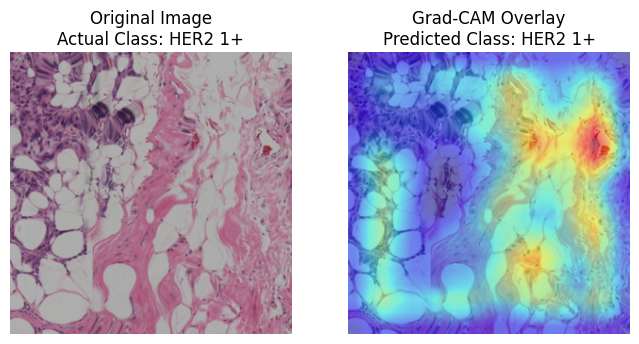

In [16]:
# --- Overlay heatmap on image ---

def overlay_heatmap(image_tensor, cam_tensor, alpha=0.5):
    # Convert image tensor to H x W x C and normalize
    image = image_tensor.permute(1, 2, 0).detach().cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min() + 1e-8)

    # Ensure cam_tensor has shape (N, C, H, W)
    if cam_tensor.dim() == 3:            # (C,H,W) or (1,H,W)
        cam_tensor = cam_tensor.unsqueeze(0)  # add batch dim
    if cam_tensor.size(1) != 1:          # ensure single channel
        cam_tensor = cam_tensor.mean(dim=1, keepdim=True)

    # Resize CAM to match image size
    cam_resized = F.interpolate(cam_tensor, size=(image.shape[0], image.shape[1]), mode='bilinear', align_corners=False)
    cam_resized = cam_resized.squeeze().detach().cpu().numpy()  # remove batch & channel dims

    # Normalize CAM between 0 and 1
    cam_resized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min() + 1e-8)

    # Apply colormap
    heatmap = plt.cm.jet(cam_resized)[:, :, :3]  # RGB

    # Blend heatmap with original image
    overlay = (1 - alpha) * image + alpha * heatmap
    overlay = np.clip(overlay, 0, 1)
    return overlay

i = 0
overlay_img = overlay_heatmap(images[i], cams[i]) # overlays heatmap

plt.figure(figsize = (8,4))
plt.subplot(1,2,1)
plt.title(f"Original Image\nActual Class: {classes[actual_classes[i]]}")
plt.imshow(images[i].permute(1,2,0).detach().cpu().numpy())
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Grad-CAM Overlay\nPredicted Class: {classes[predicted_classes[i]]}")
plt.imshow(overlay_img)
plt.axis('off')
plt.show()

cam_generator.remove_hooks()